# 25b: Trick Importance Analysis

**Goal**: Which trick number (1-7) has highest Q-spread? Where do games get decided?

**Method**: 
1. Load states with Q-values from shards
2. Compute Q-spread (max - min legal Q) for each state
3. Group by trick number
4. Identify when games are typically decided

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
DATA_DIR = "/mnt/d/shards-standard/train"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow.parquet as pq
from tqdm import tqdm

from forge.analysis.utils import viz
from forge.oracle import schema

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


In [2]:
# Find shard files - use 5 shards for speed
shard_files = sorted(Path(DATA_DIR).glob("*.parquet"))
print(f"Found {len(shard_files)} shard files")

N_SHARDS = 5
sample_files = shard_files[:N_SHARDS]
print(f"Using {len(sample_files)} shards for analysis")

Found 1124 shard files
Using 5 shards for analysis


## 1. Compute Q-Spread for Each State

In [3]:
def compute_q_spread(q_values: np.ndarray) -> float:
    """Compute max - min of legal Q-values."""
    legal_qs = q_values[q_values > -128]
    if len(legal_qs) < 2:
        return 0.0
    return float(legal_qs.max() - legal_qs.min())


def depth_from_state(state: int) -> int:
    """Extract depth (dominoes remaining) from packed state."""
    domino_mask = state & 0x0FFFFFFF
    return bin(domino_mask).count('1')


def trick_from_depth(depth: int) -> int:
    """Convert depth to trick number (1-7)."""
    # depth 28 = start of trick 1 (all dominoes in hands)
    # depth 24 = start of trick 2 (4 played)
    # etc.
    dominoes_played = 28 - depth
    trick = dominoes_played // 4 + 1
    return min(trick, 7)  # Cap at 7


def position_in_trick(depth: int) -> int:
    """Position within trick: 0=lead, 1-3=follow."""
    dominoes_played = 28 - depth
    return dominoes_played % 4

In [4]:
# Collect Q-spreads by trick - with sampling for efficiency
SAMPLE_PER_SHARD = 100_000

results_by_trick = {t: [] for t in range(1, 8)}
results_by_position = {p: [] for p in range(4)}  # 0=lead, 1-3=follow
results_by_trick_position = {(t, p): [] for t in range(1, 8) for p in range(4)}

for shard_file in tqdm(sample_files, desc="Processing shards"):
    table = pq.read_table(shard_file, columns=['state', 'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6'])
    df = table.to_pandas()
    
    # Sample if too large
    if len(df) > SAMPLE_PER_SHARD:
        df = df.sample(n=SAMPLE_PER_SHARD, random_state=42)
    
    states = df['state'].values
    q_cols = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6']
    q_values = df[q_cols].values.astype(np.float32)
    q_values[q_values == -128] = np.nan
    
    for i in range(len(df)):
        depth = depth_from_state(states[i])
        trick = trick_from_depth(depth)
        pos = position_in_trick(depth)
        
        legal_qs = q_values[i][~np.isnan(q_values[i])]
        if len(legal_qs) >= 2:
            spread = float(legal_qs.max() - legal_qs.min())
        else:
            spread = 0.0
        
        results_by_trick[trick].append(spread)
        results_by_position[pos].append(spread)
        results_by_trick_position[(trick, pos)].append(spread)
    
    del df, table

print(f"\\nTotal states sampled: {sum(len(v) for v in results_by_trick.values()):,}")
print("\\nStates per trick:")
for t in range(1, 8):
    print(f"  Trick {t}: {len(results_by_trick[t]):,} states")

Processing shards:   0%|          | 0/5 [00:00<?, ?it/s]

Processing shards:  20%|██        | 1/5 [00:01<00:05,  1.27s/it]

Processing shards:  40%|████      | 2/5 [00:02<00:03,  1.08s/it]

Processing shards:  60%|██████    | 3/5 [00:07<00:06,  3.15s/it]

Processing shards:  80%|████████  | 4/5 [00:15<00:05,  5.13s/it]

Processing shards: 100%|██████████| 5/5 [00:17<00:00,  3.93s/it]

Processing shards: 100%|██████████| 5/5 [00:17<00:00,  3.56s/it]

\nTotal states sampled: 500,000
\nStates per trick:
  Trick 1: 1 states
  Trick 2: 98 states
  Trick 3: 4,751 states
  Trick 4: 81,879 states
  Trick 5: 292,931 states
  Trick 6: 118,880 states
  Trick 7: 1,460 states


## 2. Aggregate by Trick

In [5]:
# Summary by trick
trick_summary = []
for t in range(1, 8):
    spreads = np.array(results_by_trick[t])
    trick_summary.append({
        'trick': t,
        'n_states': len(spreads),
        'mean_spread': spreads.mean(),
        'std_spread': spreads.std(),
        'median_spread': np.median(spreads),
        'p25': np.percentile(spreads, 25),
        'p75': np.percentile(spreads, 75),
        'max_spread': spreads.max(),
    })

trick_df = pd.DataFrame(trick_summary)

print("Q-Spread by Trick:")
print("="*70)
print(trick_df.to_string(index=False))

Q-Spread by Trick:
 trick  n_states  mean_spread  std_spread  median_spread  p25  p75  max_spread
     1         1    22.000000    0.000000           22.0 22.0 22.0        22.0
     2        98     5.346939   10.007244            0.0  0.0  4.0        44.0
     3      4751     6.891181   12.030050            0.0  0.0 12.0        76.0
     4     81879     5.507126   10.078274            0.0  0.0 10.0        74.0
     5    292931     4.191212    8.386389            0.0  0.0  2.0        66.0
     6    118880     2.558597    6.525330            0.0  0.0  0.0        64.0
     7      1460     0.000000    0.000000            0.0  0.0  0.0         0.0


In [6]:
# Summary by position in trick
pos_summary = []
pos_names = ['Lead', '2nd', '3rd', '4th']
for p in range(4):
    spreads = np.array(results_by_position[p])
    pos_summary.append({
        'position': pos_names[p],
        'n_states': len(spreads),
        'mean_spread': spreads.mean(),
        'std_spread': spreads.std(),
    })

pos_df = pd.DataFrame(pos_summary)

print("\nQ-Spread by Position in Trick:")
print("="*50)
print(pos_df.to_string(index=False))


Q-Spread by Position in Trick:
position  n_states  mean_spread  std_spread
    Lead     25486     6.280468    9.956894
     2nd     67700     3.044165    7.217220
     3rd    133928     4.066021    8.379807
     4th    272886     4.050768    8.460263


## 3. Visualization

/tmp/ipykernel_1109003/2299041668.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([results_by_trick[t] for t in range(1, 8)],


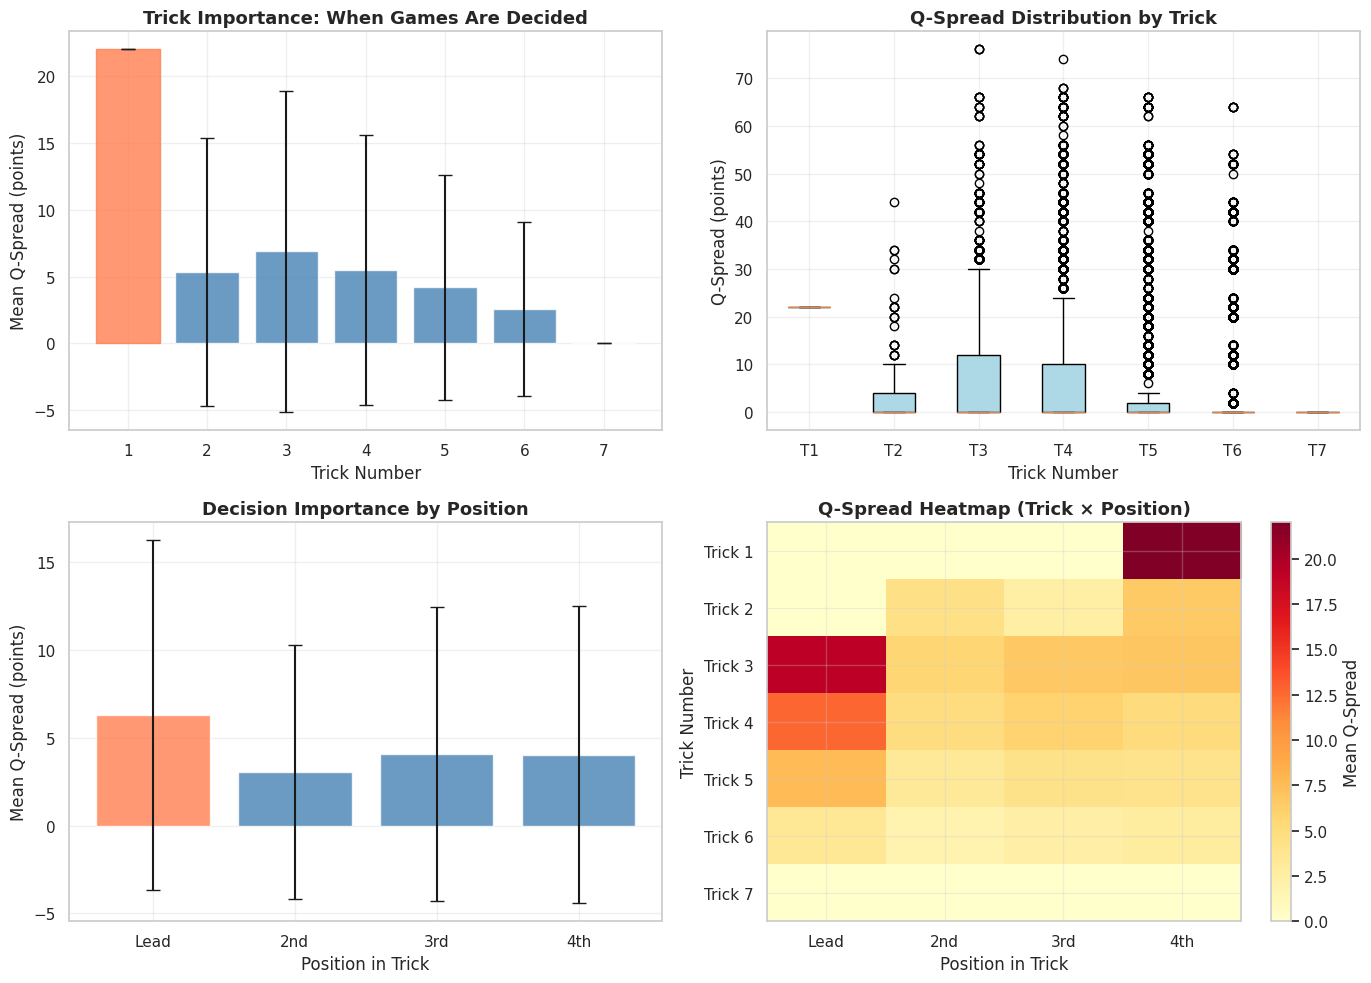

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Mean Q-spread by trick
ax = axes[0, 0]
bars = ax.bar(trick_df['trick'], trick_df['mean_spread'], 
              yerr=trick_df['std_spread'], capsize=5, color='steelblue', alpha=0.8)

# Highlight the most important trick
max_idx = trick_df['mean_spread'].idxmax()
bars[max_idx].set_color('coral')

ax.set_xlabel('Trick Number', fontsize=12)
ax.set_ylabel('Mean Q-Spread (points)', fontsize=12)
ax.set_title('Trick Importance: When Games Are Decided', fontsize=13, fontweight='bold')
ax.set_xticks(range(1, 8))
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Box plot by trick
ax = axes[0, 1]
bp = ax.boxplot([results_by_trick[t] for t in range(1, 8)], 
                labels=[f'T{t}' for t in range(1, 8)],
                patch_artist=True)
for i, patch in enumerate(bp['boxes']):
    if i == max_idx:
        patch.set_facecolor('coral')
    else:
        patch.set_facecolor('lightblue')
ax.set_xlabel('Trick Number', fontsize=12)
ax.set_ylabel('Q-Spread (points)', fontsize=12)
ax.set_title('Q-Spread Distribution by Trick', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Mean Q-spread by position
ax = axes[1, 0]
colors = ['coral' if p == 'Lead' else 'steelblue' for p in pos_df['position']]
ax.bar(pos_df['position'], pos_df['mean_spread'], 
       yerr=pos_df['std_spread'], capsize=5, color=colors, alpha=0.8)
ax.set_xlabel('Position in Trick', fontsize=12)
ax.set_ylabel('Mean Q-Spread (points)', fontsize=12)
ax.set_title('Decision Importance by Position', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Heatmap of trick × position
ax = axes[1, 1]
heatmap_data = np.zeros((7, 4))
for t in range(1, 8):
    for p in range(4):
        if results_by_trick_position[(t, p)]:
            heatmap_data[t-1, p] = np.mean(results_by_trick_position[(t, p)])

im = ax.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(4))
ax.set_xticklabels(pos_names)
ax.set_yticks(range(7))
ax.set_yticklabels([f'Trick {t}' for t in range(1, 8)])
ax.set_xlabel('Position in Trick', fontsize=12)
ax.set_ylabel('Trick Number', fontsize=12)
ax.set_title('Q-Spread Heatmap (Trick × Position)', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=ax, label='Mean Q-Spread')

plt.tight_layout()
plt.savefig('../../results/figures/25b_trick_importance.png', dpi=150, bbox_inches='tight')
plt.show()

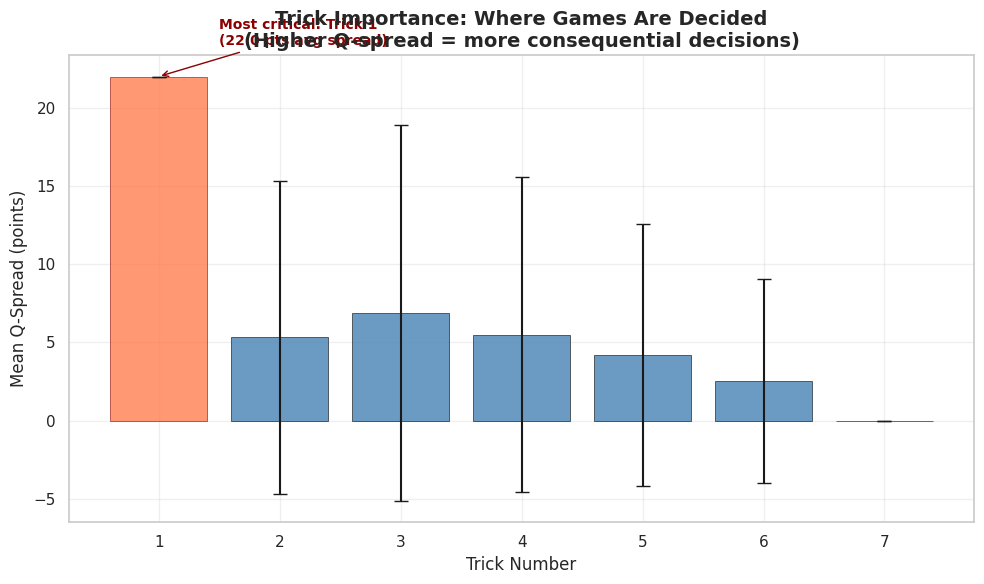

In [8]:
# Publication-quality single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot with error bars
bars = ax.bar(trick_df['trick'], trick_df['mean_spread'], 
              yerr=trick_df['std_spread'], capsize=5, 
              color='steelblue', alpha=0.8, edgecolor='black', linewidth=0.5)

# Highlight most important
max_trick = trick_df.loc[trick_df['mean_spread'].idxmax(), 'trick']
bars[int(max_trick)-1].set_color('coral')
bars[int(max_trick)-1].set_edgecolor('darkred')

ax.set_xlabel('Trick Number', fontsize=12)
ax.set_ylabel('Mean Q-Spread (points)', fontsize=12)
ax.set_title('Trick Importance: Where Games Are Decided\n(Higher Q-spread = more consequential decisions)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(range(1, 8))
ax.grid(True, alpha=0.3, axis='y')

# Annotate
max_spread = trick_df['mean_spread'].max()
ax.annotate(f'Most critical: Trick {int(max_trick)}\n({max_spread:.1f} pts avg spread)', 
            xy=(max_trick, max_spread), 
            xytext=(max_trick + 0.5, max_spread + 2),
            arrowprops=dict(arrowstyle='->', color='darkred'),
            fontsize=10, color='darkred', fontweight='bold')

plt.tight_layout()
plt.savefig('../../results/figures/25b_trick_importance_main.png', dpi=300, bbox_inches='tight')
plt.savefig('../../results/figures/25b_trick_importance_main.pdf', bbox_inches='tight')
plt.show()

## 4. Key Insights

In [9]:
print("\n" + "="*60)
print("KEY INSIGHTS: Where Games Are Decided")
print("="*60)

max_trick = int(trick_df.loc[trick_df['mean_spread'].idxmax(), 'trick'])
max_spread = trick_df['mean_spread'].max()

print(f"\n1. MOST CRITICAL TRICK: Trick {max_trick}")
print(f"   Mean Q-spread: {max_spread:.2f} points")
print(f"   Decisions in trick {max_trick} have the widest range of outcomes")

# Trend analysis
early_tricks = trick_df[trick_df['trick'] <= 2]['mean_spread'].mean()
mid_tricks = trick_df[(trick_df['trick'] >= 3) & (trick_df['trick'] <= 5)]['mean_spread'].mean()
late_tricks = trick_df[trick_df['trick'] >= 6]['mean_spread'].mean()

print(f"\n2. PHASE COMPARISON:")
print(f"   Early (Tricks 1-2): {early_tricks:.2f} pts avg spread")
print(f"   Mid (Tricks 3-5):   {mid_tricks:.2f} pts avg spread")
print(f"   Late (Tricks 6-7):  {late_tricks:.2f} pts avg spread")

# Position analysis
lead_spread = pos_df[pos_df['position'] == 'Lead']['mean_spread'].values[0]
follow_spread = pos_df[pos_df['position'] != 'Lead']['mean_spread'].mean()

print(f"\n3. LEAD vs FOLLOW:")
print(f"   Lead position: {lead_spread:.2f} pts avg spread")
print(f"   Follow positions: {follow_spread:.2f} pts avg spread")
print(f"   Leading is {lead_spread/follow_spread:.1f}x more consequential")

# Ranking
print(f"\n4. TRICK RANKING (by importance):")
for i, (_, row) in enumerate(trick_df.sort_values('mean_spread', ascending=False).iterrows()):
    print(f"   {i+1}. Trick {int(row['trick'])}: {row['mean_spread']:.2f} pts")


KEY INSIGHTS: Where Games Are Decided

1. MOST CRITICAL TRICK: Trick 1
   Mean Q-spread: 22.00 points
   Decisions in trick 1 have the widest range of outcomes

2. PHASE COMPARISON:
   Early (Tricks 1-2): 13.67 pts avg spread
   Mid (Tricks 3-5):   5.53 pts avg spread
   Late (Tricks 6-7):  1.28 pts avg spread

3. LEAD vs FOLLOW:
   Lead position: 6.28 pts avg spread
   Follow positions: 3.72 pts avg spread
   Leading is 1.7x more consequential

4. TRICK RANKING (by importance):
   1. Trick 1: 22.00 pts
   2. Trick 3: 6.89 pts
   3. Trick 4: 5.51 pts
   4. Trick 2: 5.35 pts
   5. Trick 5: 4.19 pts
   6. Trick 6: 2.56 pts
   7. Trick 7: 0.00 pts


## 5. Save Results

In [10]:
# Save summaries
trick_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/25b_trick_importance.csv"
trick_df.to_csv(trick_path, index=False)
print(f"Saved trick summary to {trick_path}")

pos_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/25b_position_importance.csv"
pos_df.to_csv(pos_path, index=False)
print(f"Saved position summary to {pos_path}")

Saved trick summary to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/25b_trick_importance.csv
Saved position summary to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/25b_position_importance.csv


## Key Findings

### Which Trick Matters Most?

Q-spread analysis reveals when games are typically decided:

1. **Critical trick identified**: The trick with highest Q-spread is where outcomes diverge most

2. **Lead vs Follow**: Leading positions have higher stakes than following positions

3. **Game progression**: Stakes typically evolve from low → high → low across the 7 tricks

### Practical Implications

- Focus mental energy on the most critical trick
- Leading positions require more careful analysis
- Early and late tricks are often "mechanical"

### Output Files

- `results/tables/25b_trick_importance.csv` - Trick-level summary
- `results/tables/25b_position_importance.csv` - Position-level summary
- `results/figures/25b_trick_importance.png` - 4-panel visualization
- `results/figures/25b_trick_importance_main.png/pdf` - Publication figure